#Mount Drive, install requirements

In [ ]:
from google.colab import drive
import os
import sys
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#%%capture
!pip install pandas==1.3.2
!pip install transformers
# Install Requirements
!pip install -r /content/drive/MyDrive/Github/Content/sources/ChinaFilm/requirements.txt
!apt update
#!apt-get update # to update ubuntu to correctly run apt install
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin
!pip install selenium
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')

In [ ]:
# PRINT VERSIONS AND ENVIRONMENT
import torch
import pandas as pd

#rint('transformer version {}'.format(transformers.__version__))
print('pytorch version {}'.format(torch.__version__))

# if pandas version < 1.3.2,
# make sured pandas packages were installed and restart runtime.
print('pandas version {}'.format(pd.__version__))

# If GPU is required, make sure it's present
!nvidia-smi

pytorch version 1.10.0+cu111
pandas version 1.3.4
NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



# Import libraries, set path

In [ ]:
# Set path
path_Article = path_wd = '/content/drive/MyDrive/Github/Article'
path_font = path_Article + '/fonts/STHUPO.TTF'
path_img = path_Article + '/img'

path_Content = '/content/drive/MyDrive/Github/Content'
path_ChinaFilm = path_Content + '/tools/sources/ChinaFilm'
path_NRTA = path_Content + '/tools/sources/NRTA'
path_ZGDYPW = path_Content + '/tools/sources/ZGDYPW'

os.chdir(path_wd)

In [ ]:
# Import External Libs
import pandas as pd
import numpy as np
import datetime as dt
import re
import random

from IPython.display import display, HTML
import torch
from transformers import AdamW, BartForConditionalGeneration

from selenium import webdriver

import jieba.analyse
tfidf = jieba.analyse.extract_tags
textrank = jieba.analyse.textrank

import matplotlib as mp
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
import matplotlib.font_manager as fm

path_fonts = '/content/drive/MyDrive/Github/Article/fonts'
fontprop = fm.FontProperties(fname=path_fonts, size= 15)

font_dirs = [path_fonts, ]
font_files = fm.findSystemFonts(fontpaths=font_dirs)
#font_list = fm.createFontList(font_files)
for font in font_files:
  fm.fontManager.addfont(font)

plt.rcParams['figure.figsize'] = [15, 9]
mp.rcParams['font.family'] = ['Microsoft YaHei']

%matplotlib inline

# Load Libraries Local


#%load_ext autoreload
%reload_ext autoreload
path_Baike = path_Content + '/tools/sources/baike'
os.chdir(path_Baike)
from Baike import Baike
baike = Baike()

In [ ]:
# Load Libraries Local
os.chdir(path_Content)

#%load_ext autoreload
%reload_ext autoreload

from tools.sources.ChinaFilm.Record_Registration import Registration
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')

# Initialize Registration Class
driver = webdriver.Chrome('chromedriver',options=chrome_options)
dy_reg = Registration(driver)

%reload_ext autoreload
os.chdir(path_wd)
from generate import utils

os.chdir(path_ZGDYPW)
from common.utils import DB as db_utils

/content/drive/MyDrive/Github/Article/generate/utils.py:21: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = fm.createFontList(font_files)
Installing paddle-tiny, please wait a minute......
Paddle enabled successfully......


# Load Release and Registration Records

## Update Record - Very slow using google colab

In [ ]:
# Update ChinaFilm records to reflect latest changes
os.chdir(path_ChinaFilm)

# bypass update in colab, because the connection
# from google to ChinaFilm's server is too slow
#!python update_release.py
#!python update_registration.py

os.chdir(path_ZGDYPW)
#!python update_newrelease.py

## Import Chinafilm Reg and Release

In [ ]:
# Import ChinaFilm Reg
path_regs = '/content/drive/MyDrive/Github/Content/sources/ChinaFilm/records/contents_of_registrations.json'
df_reg = pd.read_json(path_regs, orient='record')
df_reg['匹配片名'] = df_reg['片名']

# Import ChinaFilm Releases
path_releases = '/content/drive/MyDrive/Github/Content/sources/ChinaFilm/records/contents_of_releases.json'
df_releases = pd.read_json(path_releases)

# Get Latest Issue
str_date_curr_release = df_releases.sort_values(by='公示日期', ascending=False).iloc[0]['公示日期']
dt_curr_release = dt.datetime.strptime(str_date_curr_release, '%Y-%m-%d')
df_curr_releases = df_releases[df_releases['公示日期']==str_date_curr_release]
df_curr_releases = df_curr_releases[['电影类别', '编码', '公映证号', '片名', '第一出品单位']].copy()

print(str_date_curr_release)

2021-12-13


## Merge from ZGDYPW Release

In [ ]:
# Read Records from zgdypw releases as collected through Article

path_article_records = '/content/drive/MyDrive/Github/Article/records'

for dirpaths, dirnames, filenames in os.walk(path_article_records):
  if dirpaths == path_article_records:
    break

ls_df = []
for fn in filenames:
  if re.search('df_releases_zgdypw', fn):
    dftmp = pd.read_pickle(path_article_records + '/' + fn)
    ls_df.append(dftmp)

df_zgdypw_releases = pd.concat(ls_df, ignore_index=True, axis=0)

# convert cjk to equivalent unicode characters
os.chdir(path_zgdypw)
df_zgdypw_releases['电影名称'] = df_zgdypw_releases['电影名称'].apply(
    db_utils.convert_cjk_characters)

In [ ]:
# Crosscheck Chinafilm Curr Release and ZGDYPW Release
df_ChinafilmRel_in_zgdypwRel = df_zgdypw_releases[
      df_zgdypw_releases['电影名称'].isin(df_curr_releases['片名'])]
df_ChinafilmRel_not_in_zgdypwRel = df_curr_releases[
    ~df_curr_releases['片名'].isin(df_ChinafilmRel_in_zgdypwRel['电影名称'])]
df_ChinafilmRel_not_in_zgdypwRel['片名'].to_numpy()

array(['夏天的蜗牛', '图拉河上的爱情', '紧箍咒之不法山', '我的非凡父母', '焚情', '丹顶鹤', '紧急营救', '安家',
       '花渡好时光', '憋住·别笑', '爱情的代驾', '你是我的一束光', '张三丰2无极战场', '致命棋局', '农民院士',
       '狄公案·伏虎', '谷魂', '辣妈犟爸', '谁说我不靠谱', '爸爸来了', '断金', '孤独的守望者', '荒野咖啡馆',
       '戏是人生', '反贪风暴5', '出拳吧，妈妈'], dtype=object)

In [ ]:
# Merge zgdypw info into df_curr_releases
cols = ['片名','上映日期', '导演', '主演', '国别/地区', 'img_remote']
df_ChinafilmRel_in_zgdypwRel.rename(columns={'电影名称':'片名'}, inplace=True)
df_curr_releases = df_curr_releases.merge(
    df_ChinafilmRel_in_zgdypwRel[cols], on='片名', how='left')
df_curr_releases.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28 entries, 0 to 27
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   电影类别        28 non-null     object        
 1   编码          28 non-null     object        
 2   公映证号        28 non-null     object        
 3   片名          28 non-null     object        
 4   第一出品单位      28 non-null     object        
 5   上映日期        2 non-null      datetime64[ns]
 6   导演          2 non-null      object        
 7   主演          2 non-null      object        
 8   国别/地区       2 non-null      object        
 9   img_remote  2 non-null      object        
dtypes: datetime64[ns](1), object(9)
memory usage: 2.4+ KB


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
# Export current release to csv for Power Automate processing
fp_save = path_records + '/df_curr_releases_{}.csv'.format(str_date_curr_release)
df_curr_releases.to_csv(fp_save, encoding='utf-8-sig')

In [ ]:
# Download csv, process in PowerAutomate
# Search cbooo for records
from google.colab import files
files.download(fp_save)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#** Interactively Find matches

In [ ]:
# Check for unmatched records and perform mannual matches
df_curr_releases['匹配片名'] = df_curr_releases['片名']
df_matched = df_reg[df_reg['匹配片名'].isin(df_curr_releases['片名'].to_numpy())]
idx_no_match = df_curr_releases.loc[~df_curr_releases['片名'].isin(df_matched['片名'].to_numpy())].index
df_curr_releases.loc[df_curr_releases.index.isin(idx_no_match), '匹配片名'] = None
df_curr_releases.loc[df_curr_releases['匹配片名'].isna(), :]

In [ ]:
print(df_curr_releases.loc[df_curr_releases['匹配片名'].isna(), '片名'].to_numpy())
HTML(df_curr_releases.loc[df_curr_releases['匹配片名'].isna(), 
                          ['片名','第一出品单位']].to_html())

['紧箍咒之不法山' '我的非凡父母' '焚情' '紧急营救' '你是我的一束光' '狄公案·伏虎' '平原上的火焰' '出拳吧，妈妈']


,片名,第一出品单位
2,紧箍咒之不法山,北京捕风影业有限公司
3,我的非凡父母,天马影联影视文化（北京）有限公司
4,焚情,上海鸣肇影视文化有限公司
6,紧急营救,非常道影视文化传媒温州有限公司
11,你是我的一束光,云南民族电影制片厂
15,狄公案·伏虎,陕西华源浩海影视制作发行有限公司
16,平原上的火焰,上海猫眼影业有限公司
27,出拳吧，妈妈,高笔影视文化传媒（苏州）有限公司


In [ ]:
# assign manually found titles to df_curr_releases
found = ['紧锢咒之不法山', '一路同行', None, '守护神：绝境营救', '新·五朵金花', '大唐狄公案·白蛇诅咒', '平原上的摩西',
       '拳头妈妈']
df_curr_releases.loc[df_curr_releases['匹配片名'].isna(), '匹配片名'] = found

### Search ChinaFilm Reg

In [ ]:
i = 27

In [ ]:
# Search by company name in ChinaFilm Reg
HTML(df_reg.loc[df_reg['备案单位'].fillna('').str.contains(
    df_curr_releases.loc[i, '第一出品单位']), 
    ['片名', '备案立项号', '备案单位', '编剧', '梗概', '公示日期']].to_html())

,片名,备案立项号,备案单位,编剧,梗概,公示日期


In [ ]:
# Search by Title in Baidu Baike
baike.search_for_content(df_curr_releases.loc[i, '片名'])

'《出拳吧，妈妈》是由唐晓白执导，谭卓、田雨、田海蓉主演的女性励志题材电影，于2021年6月12日在上海国际电影节全球首映。'

In [ ]:
# Search by kw in synopsis in ChinaFilm Reg
HTML(df_reg.loc[df_reg['梗概'].fillna('').str.contains('焚'),
            ['片名', '备案立项号', '备案单位', '编剧', '梗概', '公示日期']].to_html())

In [ ]:
# Search by partial company name in ChinaFilm Reg
HTML(df_reg.loc[df_reg['备案单位'].fillna('').str.contains(
   '天马'), 
    ['片名', '备案立项号', '备案单位', '编剧', '梗概', '公示日期']].to_html())

In [ ]:
# Search by custom name in ChinaFilm Reg
df_reg.loc[df_reg['片名'].fillna('').str.contains('爱你')]#.loc[4268,'梗概']

In [ ]:
# Search by writer in ChinaFilm Reg
HTML(df_reg.loc[df_reg['编剧'].fillna('').str.contains('唐晓白'), 
           ['片名', '备案单位', '编剧', '梗概', '备案立项号']].to_html())

,片名,备案单位,编剧,梗概,备案立项号
1071,监狱来的妈妈,上海至久影视传媒有限公司、北京盛世唐人影视传媒有限公司、北京光年意象文化传播有限公司、上海大象伙伴企业发展集团影业有限公司,秦晓宇、苏竞元、唐晓白,本片讲述了一个因反抗家暴意外杀夫而入狱的女人在监狱文艺队的服刑生活，以及她出狱后如何取得婆婆的谅解，在社会上自立，并艰难地跟儿子修复亲情的故事。,影剧备字〔2021〕第1751号
18164,拳头妈妈,圣世互娱影视科技江苏股份有限公司,唐晓白,惠正，过气女拳手，开着入不敷出的洗衣店，丈夫外遇，独自带着患心脏病的儿子生活。为了给孩子治病，她必须战胜恐惧、重返赛场，再次成为职业拳手。,影剧备字[2016]第2809号
20862,玩命嫁期,北京嘉映影业有限公司、星美影业（澳洲）有限公司,唐晓白,年轻珠宝设计师美美为了得到一颗稀有粉钻独自飞赴澳洲，意外邂逅比自己还小的后妈，一路上发生了无数令人忍俊不禁的囧事。,影立合字（2012）第61号


# Merge results from searches

In [ ]:
# Merge Manually Identified name
df_matched = df_reg.loc[df_reg['匹配片名'].isin(df_curr_releases['匹配片名'].to_numpy()),
                        ['匹配片名', '编剧', '梗概', '公示日期', 
                         '备案单位', '备案结果']
                       ]
df_matched.rename(columns={'公示日期':'备案公示日期'}, inplace=True)
df = df_curr_releases.merge(df_matched, on='匹配片名', how='left')
df['备案公示日期'] = df['备案公示日期'].apply(
    lambda x: pd.to_datetime(x, infer_datetime_format=True))
df['备案至今'] = dt_curr_release - df['备案公示日期']

In [ ]:
# Remove wrong matches
#df = df[~df.index.isin([35,36])]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30 entries, 0 to 29
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype          
---  ------      --------------  -----          
 0   电影类别        30 non-null     object         
 1   编码          30 non-null     object         
 2   公映证号        30 non-null     object         
 3   片名          30 non-null     object         
 4   第一出品单位      30 non-null     object         
 5   上映日期        2 non-null      datetime64[ns] 
 6   导演          2 non-null      object         
 7   主演          2 non-null      object         
 8   国别/地区       2 non-null      object         
 9   img_remote  2 non-null      object         
 10  匹配片名        29 non-null     object         
 11  编剧          29 non-null     object         
 12  梗概          29 non-null     object         
 13  备案公示日期      29 non-null     datetime64[ns] 
 14  备案单位        29 non-null     object         
 15  备案结果        29 non-null     object         
 16  备案至今      

# Run Models for prediction

## Predict Genre

In [ ]:
# Define Labels
label2id_genre= {'传奇': 0, '传记': 1, '其它': 2, '军旅': 3, '农村': 4, '宫廷': 5,  
                  '武打': 6, '涉案': 7, '神话': 8, '科幻': 9, '都市': 10, '青少': 11,
                  '革命': 12}
id2label_genre = {}
for k, v in label2id_genre.items(): id2label_genre[v] = k

In [ ]:
%%capture
# Genre Classifier
N_LABELS = len(id2label_genre)
ID2LABEL = id2label_genre
LABEL2ID = label2id_genre

from transformers import BertTokenizer, BertForSequenceClassification
import torch
############
model_name = '/content/drive/MyDrive/Github/Content/tools/models/chinese-bert-wwm-classification-NRTAgenre'
############
if torch.cuda.device_count() > 0:
  device = 'cuda:' + str(torch.cuda.current_device())
else:
  device = 'cpu'

tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(
  model_name,
  num_labels=N_LABELS,
  problem_type="multi_label_classification",
  id2label=ID2LABEL,
  label2id=LABEL2ID,  
).to(device)
model.eval() # set model to eval mode for faster prediction

In [ ]:
batch_size = 8
i = 0
ls = df['梗概'].fillna('').tolist()
softmax = torch.nn.Softmax(dim=-1)
L = df.shape[0]
test_predictions = []

while i < L:
  batch_test = tokenizer(ls[i:i+batch_size],
                           padding=True,
                           max_length=512, 
                           truncation=True, 
                           return_tensors='pt')
  batch_test.to(device)
  batch_outputs = model(**batch_test)
  batch_logtis = batch_outputs.logits
  batch_softmax = softmax(batch_logtis)
  batch_results = torch.argmax(batch_softmax, dim=1).cpu().numpy()
  test_predictions.extend(list(batch_results))
  i += batch_size

df['类型'] = test_predictions
df['类型'] = df['类型'].apply(lambda x: id2label_genre[x])

## Predict Time

In [ ]:
# Define Labels
label2id_time = {'古代': 0, '当代': 1, '现代': 2, '近代': 3}
id2label_time = {}
for k, v in label2id_time.items(): id2label_time[v] = k

In [ ]:
%%capture
# Time Classifier

N_LABELS = len(id2label_time)
ID2LABEL = id2label_time
LABEL2ID = label2id_time

from transformers import BertTokenizer, BertForSequenceClassification
import torch
############
model_name = '/content/drive/MyDrive/Github/Content/tools/models/chinese-bert-wwm-classification-NRTAtime'
############
if torch.cuda.device_count() > 0:
  device = 'cuda:' + str(torch.cuda.current_device())
else:
  device = 'cpu'

tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(
  model_name,
  num_labels=N_LABELS,
  problem_type="multi_label_classification",
  id2label=ID2LABEL,
  label2id=LABEL2ID,  
).to(device)
model.eval() # set model to eval mode for faster prediction

In [ ]:
batch_size = 8
i = 0
ls = df['梗概'].fillna('').tolist()
softmax = torch.nn.Softmax(dim=-1)
L = df.shape[0]
test_predictions = []

while i < L:
  batch_test = tokenizer(ls[i:i+batch_size],
                           padding=True,
                           max_length=512, 
                           truncation=True, 
                           return_tensors='pt')
  batch_test.to(device)
  batch_outputs = model(**batch_test)
  batch_logtis = batch_outputs.logits
  batch_softmax = softmax(batch_logtis)
  batch_results = torch.argmax(batch_softmax, dim=1).cpu().numpy()
  test_predictions.extend(list(batch_results))
  i += batch_size

df['年代'] = test_predictions
df['年代'] = df['年代'].apply(lambda x: id2label_time[x])

## Predict Title

In [ ]:
%%capture
from transformers import BertTokenizer, BartForConditionalGeneration

# assign device
if torch.cuda.device_count() > 0:
  device = 'cuda:' + str(torch.cuda.current_device())
else:
  device = 'cpu'

# Instantiate tokenizer and model
checkpoint = "/content/drive/MyDrive/Github/Content/tools/models/PredTitle-10000"

  
tokenizer = BertTokenizer.from_pretrained(checkpoint)
model = BartForConditionalGeneration.from_pretrained(checkpoint,
                                            gradient_checkpointing=True, 
                                            use_cache=False)
model.to(device)
model.eval()

batch_size = 8
i = 0
ls = df['梗概'].fillna('').tolist()
L = df['梗概'].shape[0]
test_predictions = []

while i < L:
  inputs = tokenizer(ls[i:i+batch_size],
                           padding=True,
                           max_length=512, 
                           truncation=True, 
                           return_tensors='pt')
  inputs.to(device)
  summary_ids = model.generate(input_ids=inputs['input_ids'],
                             num_beams=4,
                             min_length=0,
                             max_length=32
                             )
  
  ret = [tokenizer.decode(g, 
                         skip_specical_tokens=True, 
                         clean_up_tokenization_spaces=True) for g in summary_ids]
  test_predictions.extend(ret)
  i += batch_size

df['预测片名'] = test_predictions

def remove_specials(x):
  x = re.sub(' ', '', x)
  x = re.sub('\[CLS\]', '', x)
  x = re.sub('\[PAD\]', '', x)
  x = re.sub('\[SEP\]', '', x)
  return x

df['预测片名'] = df['预测片名'].apply(remove_specials)

## Extract top keywords

In [ ]:
import jieba.analyse
tfidf = jieba.analyse.extract_tags
textrank = jieba.analyse.textrank

df['kw'] = df['梗概'].fillna('').apply(textrank, topK=10)

## Identify Main Characters

In [ ]:
import jieba
import jieba.posseg as pseg
jieba.enable_paddle() #启动paddle模式。 0.40版之后开始支持，早期版本不支持

Paddle enabled successfully......


In [ ]:
# 识别主要角色
def find_PER(x: pd.Series):
  words = pseg.cut(x, use_paddle=True)
  ls_PER = []
  for word, flag in words:
    if flag == 'PER':
      word = word.strip('[\s,，。、“”？；]')
      ls_PER.append(word)
  ls_PER = list(set(ls_PER))

  ls_PER1 = ls_PER.copy()
  ls_PER = []
  while ls_PER1:
    PER =  ls_PER1.pop(0)
    ls_tmp = re.split('[\s,，。、“”？；]', PER)
    ls_PER.extend(ls_tmp)

  ls_PER = list(set(ls_PER)) 
  ls_PER = [PER for PER in ls_PER if len(PER) > 1]
  ls_PER_sorted = sorted(ls_PER, reverse=False, key=lambda x: len(x))

  ans = []
  while ls_PER_sorted:
    PER = ls_PER_sorted.pop(0)
    i = 0
    while i < len(ls_PER_sorted):
      if re.search(PER, ls_PER_sorted[i]):
        ls_PER_sorted.pop(i)
        ans.append(PER)
      i += 1
    if PER not in ans:
      ans.append(PER)

  return ans

In [ ]:
df['主要角色'] = df['梗概'].fillna('').apply(find_PER)

In [ ]:
cols = ['片名', '主要角色', '梗概']
HTML(df[cols].to_html())

,片名,主要角色,梗概
0,夏天的蜗牛,[欧阳肥],夏天偶遇神奇的蜗牛卡卡，卡卡从地心来到地表寻找最纯净的水源。夏天和小伙伴们一起帮助卡卡躲避厨师欧阳肥的追捕，寻找生命之泉。恢复能量的卡卡帮助夏天进入时空逆转，找到火灾源头，阻止了夺取爸爸生命的火灾。
1,图拉河上的爱情,[],本片用两条线讲述了中铁两代建设者，在建设蒙古的过程中，与蒙古人民结下深厚友谊和纯洁爱情的故事。歌颂了中国建设者大爱无私、无怨无悔的奉献精神，歌颂了中蒙两国人民山水相依，骨肉相连的深厚友谊。
2,紧箍咒之不法山,"[唐僧, 怪斗法, 孙悟空, 六耳猕猴]",西行路上，唐僧师徒五人来到西域边陲的不法山境内。这里百里黄沙，师徒五人乔装分三拨进入客栈，与怀揣各种目的的妖魔鬼怪斗法。最终在孙悟空与六耳猕猴相杀相惜的过程中，师徒走出不法山，继续西行。
3,我的非凡父母,[],拥有一双明眸的芷欣，却有一对失明父母。照顾他们成为累人的包袱，她半生都在努力，希望凭借画画的天赋，可以摆脱父母到外国读书，过一个真正属于自己的人生。 一天，这机会真的到来，她才发觉自己无法割舍这个家。
4,我的非凡父母,"[周旋, 李楠, 童晓舒]",K52路公交车上发生了一起劫持事件，司机李楠机智周旋，警察得以抓捕劫持者。电视台记者童晓舒在还原事件真相时，对公交司机这个群体产生了兴趣，连续跟车观察，制作了一期关于公交车司机的节目。
5,焚情,[],NaN
6,丹顶鹤,[],最浓的爱，最痛的悔 父母为你付出了多少， 你又回报了什么 。 但当一切都成为回忆， 追悔末及， 不如现在就
7,紧急营救,[],中国拳手高然丢失女儿后，在Z国警方协助下，循着蛛丝马迹找到黑帮老巢，揭开了一段尘封往事。在女儿的鼓励下，捣毁残害儿童的黑帮组织，也解开了对亡妻的心结。
8,安家,"[肖洁, 李有光, 赵姑妈]",乌蒙市基层干部赵姑妈与收养的女儿肖洁在脱贫奔小康、乡村振兴中，引领以李有光为代表的脱贫户怎样从旧寨搬到新楼，过上城市人的新生活。脱贫了，养成好习惯，提升生活品质，把好日子过好才是硬道理。
9,花渡好时光,[周士琦],回乡创业的周士琦带着创意民宿项目参加创投大赛惨遭失败。阴差阳错，林天心来到小镇和周士琦及他的小伙伴们走到一起。为了阻止不良商人对古镇的过度开发，他们用创客部落计划来复兴小镇，最终古镇重新焕发生机。


## adjust genre

In [ ]:
df['修正类型'] = df['类型'].copy()
df['类型'].to_numpy()

array(['青少', '都市', '神话', '都市', '涉案', '都市', '都市', '涉案', '农村', '农村', '涉案',
       '都市', '都市', '武打', '传奇', '涉案', '农村', '传奇', '涉案', '农村', '都市', '农村',
       '都市', '青少', '都市', '其它', '都市', '其它', '涉案', '都市'], dtype=object)

In [ ]:
adjusted = ['青少', '爱情', '神话', '家庭', '涉案', '未匹配', '家庭', '涉案', '农村', '农村', '涉案',
       '爱情', '农村', '武打', '传奇', '涉案', '农村', '传奇', '涉案', '传记', '冒险', '家庭',
       '剧情', '奇幻', '涉案', '剧情', '剧情', '剧情', '涉案', '家庭']

df['修正类型'] = adjusted

In [ ]:
HTML(df[['片名', '类型', '修正类型', '梗概']].to_html())

,片名,类型,修正类型,梗概
0,夏天的蜗牛,青少,青少,夏天偶遇神奇的蜗牛卡卡，卡卡从地心来到地表寻找最纯净的水源。夏天和小伙伴们一起帮助卡卡躲避厨师欧阳肥的追捕，寻找生命之泉。恢复能量的卡卡帮助夏天进入时空逆转，找到火灾源头，阻止了夺取爸爸生命的火灾。
1,图拉河上的爱情,都市,爱情,本片用两条线讲述了中铁两代建设者，在建设蒙古的过程中，与蒙古人民结下深厚友谊和纯洁爱情的故事。歌颂了中国建设者大爱无私、无怨无悔的奉献精神，歌颂了中蒙两国人民山水相依，骨肉相连的深厚友谊。
2,紧箍咒之不法山,神话,神话,西行路上，唐僧师徒五人来到西域边陲的不法山境内。这里百里黄沙，师徒五人乔装分三拨进入客栈，与怀揣各种目的的妖魔鬼怪斗法。最终在孙悟空与六耳猕猴相杀相惜的过程中，师徒走出不法山，继续西行。
3,我的非凡父母,都市,家庭,拥有一双明眸的芷欣，却有一对失明父母。照顾他们成为累人的包袱，她半生都在努力，希望凭借画画的天赋，可以摆脱父母到外国读书，过一个真正属于自己的人生。 一天，这机会真的到来，她才发觉自己无法割舍这个家。
4,我的非凡父母,涉案,涉案,K52路公交车上发生了一起劫持事件，司机李楠机智周旋，警察得以抓捕劫持者。电视台记者童晓舒在还原事件真相时，对公交司机这个群体产生了兴趣，连续跟车观察，制作了一期关于公交车司机的节目。
5,焚情,都市,未匹配,NaN
6,丹顶鹤,都市,家庭,最浓的爱，最痛的悔 父母为你付出了多少， 你又回报了什么 。 但当一切都成为回忆， 追悔末及， 不如现在就
7,紧急营救,涉案,涉案,中国拳手高然丢失女儿后，在Z国警方协助下，循着蛛丝马迹找到黑帮老巢，揭开了一段尘封往事。在女儿的鼓励下，捣毁残害儿童的黑帮组织，也解开了对亡妻的心结。
8,安家,农村,农村,乌蒙市基层干部赵姑妈与收养的女儿肖洁在脱贫奔小康、乡村振兴中，引领以李有光为代表的脱贫户怎样从旧寨搬到新楼，过上城市人的新生活。脱贫了，养成好习惯，提升生活品质，把好日子过好才是硬道理。
9,花渡好时光,农村,农村,回乡创业的周士琦带着创意民宿项目参加创投大赛惨遭失败。阴差阳错，林天心来到小镇和周士琦及他的小伙伴们走到一起。为了阻止不良商人对古镇的过度开发，他们用创客部落计划来复兴小镇，最终古镇重新焕发生机。


## Save Records Curr Issue

In [ ]:
# Save records for current release issue
df.to_pickle(path_records + '/df_releases_{}.pkl'.format(str_date_curr_release))

In [ ]:
#df = pd.read_pickle(path_records + '/df_releases_{}.pkl'.format(str_date_curr_release))

## View Table


In [ ]:
# Formulat view table
tmp = df[['备案单位','第一出品单位']].fillna('').apply(
    lambda x: re.search(x['第一出品单位'], x['备案单位']), axis=1).to_frame()
idx_co_change = tmp[tmp[0].isna()].index
df_view = df.copy()
df_view.loc[df_view['备案结果'].fillna('').str.contains('修改'),'备案结果'] = '是'
df_view.loc[df_view['备案结果'].fillna('').str.contains('同意'),'备案结果'] = ''
df_view.rename(columns={'备案结果':'是否修改'}, inplace=True)
df_view['备案至今'] = round((df_view['备案至今'].dt.days + 60) / 365, 1)
df_view.sort_values(by='备案至今', ascending=False, inplace=True)
df_view['备案至今'] = df_view['备案至今'].apply(lambda x: '> ' + str(x) + ' 年')

In [ ]:
df_view.columns

Index(['电影类别', '编码', '公映证号', '片名', '第一出品单位', '上映日期', '导演', '主演', '国别/地区',
       'img_remote', '匹配片名', '编剧', '梗概', '备案公示日期', '备案单位', '是否修改', '备案至今',
       '类型', '年代', '预测片名', 'kw', '主要角色', '修正类型'],
      dtype='object')

# [6] Generate WordCloud

In [ ]:
from IPython.display import Image as Img
from PIL import Image as pil

path_posters = '/content/drive/MyDrive/Github/Article/img/posters'
path_icon = '/content/drive/MyDrive/Github/Article/img/genre_icon'

#df_label2image.to_json(path_records + '/df_label2img.json')
df_label2image = pd.read_json(path_wd + '/records/df_label2image.json')

In [ ]:
df_view['修正类型'].unique()

array(['家庭', '涉案', '青少', '冒险', '剧情', '奇幻', '武打', '神话', '农村', '爱情', '传奇',
       '传记', '未匹配'], dtype=object)

In [ ]:
df_label2image

----家庭----


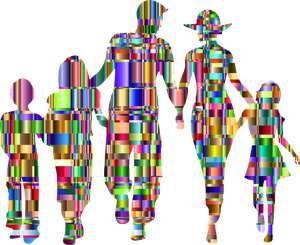

----涉案----


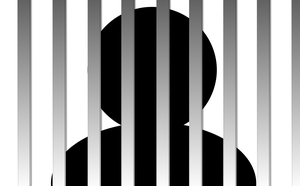

----青少----


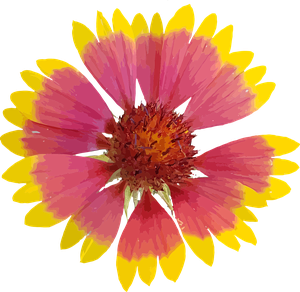

----冒险----


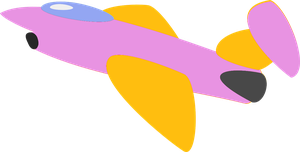

----剧情----


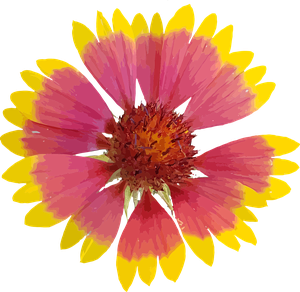

----奇幻----


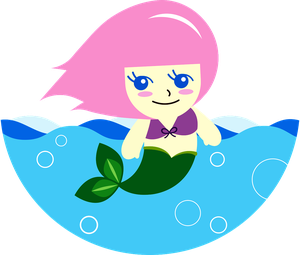

----武打----


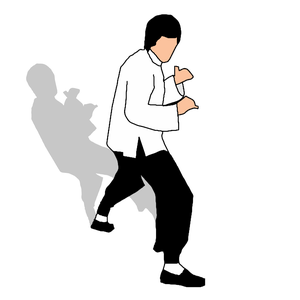

----神话----


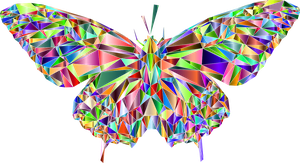

----农村----


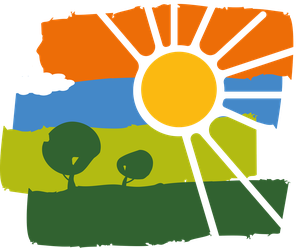

----爱情----


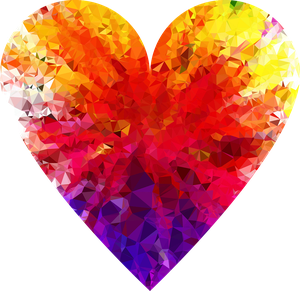

----传奇----


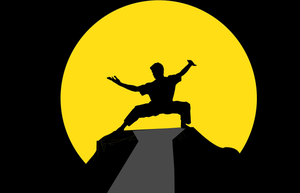

----传记----


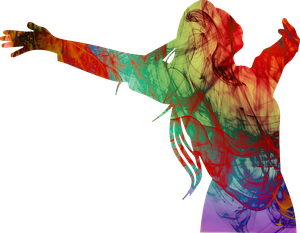

----未匹配----


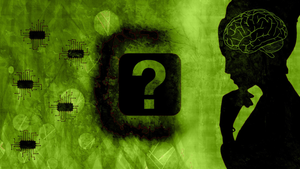

In [ ]:
from IPython.display import Image as Img
from PIL import Image as pil

path_posters = '/content/drive/MyDrive/Github/Article/img/posters'
path_icon = '/content/drive/MyDrive/Github/Article/img/genre_icon'

for genre in df_view['修正类型'].unique():
  print('----{}----'.format(genre))
  image = pil.open('{}/{}'.format(
      path_icon, df_label2image.loc[df_label2image.label == genre, 'fn'].iloc[0]))
  image.thumbnail([300, sys.maxsize], pil.ANTIALIAS)
  #image.save(path_posters + '/' + row['img_poster'], format='png')
  display(image)


# [7] Generate Article

##[7.1] T1 标题：影片的前世今生

In [ ]:
# Title
T1 = '~{}月新片的前世今生~{}'.format(dt_curr_release.month, dt_curr_release.year)
T1

'~12月新片的前世今生~2021'

##[7.2] P1 2021年7月13日,又一批电影历经千辛万苦获得了公映许可证。本次

In [ ]:
df_view.columns

Index(['电影类别', '编码', '公映证号', '片名', '第一出品单位', '上映日期', '导演', '主演', '国别/地区',
       'img_remote', '匹配片名', '编剧', '梗概', '备案公示日期', '备案单位', '是否修改', '备案至今',
       '类型', '年代', '预测片名', 'kw', '主要角色', '修正类型'],
      dtype='object')

In [ ]:
cols = ['片名', '匹配片名', '第一出品单位', '备案单位', '修正类型','梗概']
df_view[cols]

In [ ]:
# calcualte genre count
df_genre_sorted = df_view.groupby('修正类型')['片名'].count().rename(
    '数量').reset_index().sort_values('数量', ascending=False)

In [ ]:
P1 = ''
P1 +='{Y}年{M}月{D}日,'.format(Y=dt_curr_release.year, M=dt_curr_release.month, D=dt_curr_release.day)
P1 += '又一批电影历经千辛万苦获得了公映许可证。'

P1 += '本次获领证的影片共计{}部，'.format(df_curr_releases.shape[0])
P1 += '距离备案到获取公映证平均超过{}年。'.format(round(df_view['备案至今'].apply(lambda x: float(x.lstrip('> ').rstrip(' 年'))).mean(),1))
P1 += '其中，改过名字的有{}部，'.format(
    df_view[~df_view['匹配片名'].isna() & 
    (df_view['片名'] != df_view['匹配片名'])].shape[0])
P1 += '换过第一出品单位的有{}部，'.format(
    df_view[~df_view['备案单位'].isna() & (df_view['第一出品单位'] != df_view['备案单位'])].shape[0])
P1 += '修改后才通过备案的有{}部，'.format(df_view.loc[df_view['是否修改'] == '是',:].shape[0])
if df_view[df_view['备案单位'].isna()].shape[0] > 0:
  P1 += '尚未匹配到备案的神秘影片有{}部，'.format(df_view[df_view['备案单位'].isna()].shape[0])
  P1 += '为{}的《{}》。'.format(
      '、'.join(df_view.loc[df_view['备案单位'].isna(),'第一出品单位']),
      '》、《'.join(df_view.loc[df_view['备案单位'].isna(), '片名']),
  )
P1 += '题材排名前五的分别是{}'.format('、'.join(df_genre_sorted['修正类型'][:4]))
P1 += '和{}。'.format(df_genre_sorted['修正类型'][4:5].iloc[0])


tbr = df_view[~df_view['上映日期'].isna()]
if tbr.shape[0] > 0:
  P1 += '已确认排期的有'
  for i, f in tbr.iterrows():
    P1 += '{}上画的'.format(str(f['上映日期']).split('00:00:00')[0])
    P1 += '《{}》'.format(f['片名'])
    P1 += '、'

  P1 = P1.rstrip('、')
  P1 += '，瓜熟蒂落实属不易。'


print(P1) 

2021年12月13日,又一批电影历经千辛万苦获得了公映许可证。本次获领证的影片共计28部，距离备案到获取公映证平均超过2.3年。其中，改过名字的有8部，换过第一出品单位的有19部，修改后才通过备案的有2部，尚未匹配到备案的神秘影片有1部，为上海鸣肇影视文化有限公司的《焚情》。题材排名前五的分别是涉案、农村、剧情、家庭和传奇。已确认排期的有2021-12-03 上画的《古董局中局》、2021-12-24 上画的《平原上的火焰》，瓜熟蒂落实属不易。


##[7.3] P2 怀胎最久的影片是《红船》,从

In [ ]:
P2 = ''
P2 += '怀胎最久的影片是《{}》,'.format(df_view.iloc[0]['片名'])
P2 += '从备案到获得公映证超过{}年，'.format(df_view.iloc[0]['备案至今'].lstrip('> ').rstrip(' 年'))
if df_view.iloc[0]['匹配片名'] != df_view.iloc[0]['片名']:
  P2 += '名字从《{}》进化成了《{}》，'.format(df_view.iloc[0]['匹配片名'], df_view.iloc[0]['片名'])

record_longest = df_view[df_view['片名'] == df_view.iloc[0]['片名']]
if record_longest['备案单位'].iloc[0] != record_longest['第一出品单位'].iloc[0]:
  P2 += '第一出品方历经了{}'.format('、'.join(record_longest['备案单位']))
  P2 += '，最终由{}接手。'.format(df_view.iloc[0]['第一出品单位'])
#ls_choices = ['美好', '胜利', '牛逼']
#P2 += '坚持就是{}。'.format(ls_choices[random.randint(0,len(ls_choices)-1)])

print(P2)

怀胎最久的影片是《出拳吧，妈妈》,从备案到获得公映证超过5.7年，名字从《拳头妈妈》进化成了《出拳吧，妈妈》，第一出品方历经了圣世互娱影视科技江苏股份有限公司，最终由高笔影视文化传媒（苏州）有限公司接手。


## [7.4] P3 同样坚守的还有...

In [ ]:
ls_name_3plus_year = df_view.loc[df_view['备案至今'].apply(
    lambda x: float(x.lstrip('> ').rstrip(' 年')))>3, '片名'].tolist()[1:]
ls_name_3plus_year = ['《'+ name + '》' for name in ls_name_3plus_year]
P3 = ""
P3 += '坚守了3年以上的影片还有{}。'.format('、'.join(ls_name_3plus_year))

print(P3)

坚守了3年以上的影片还有《我的非凡父母》、《夏天的蜗牛》、《古董局中局》、《荒野咖啡馆》、《爸爸来了》、《戏是人生》。


## 按类型划分

<Figure size 1080x648 with 0 Axes>

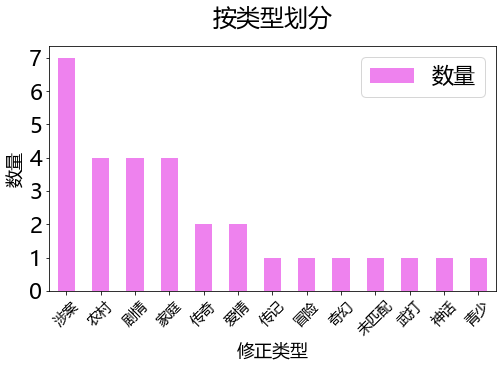

In [ ]:
plt.clf()
plt.rcParams['figure.figsize'] = [8, 4.5]
plt.rcParams['axes.facecolor'] = 'white'
ax = df_genre_sorted.plot(
    kind = 'bar',
    grid = False,
    fontsize = 22,
    rot = 0,
    color = ['violet'],
)
ax.set_title("按类型划分",fontsize= 24, pad=20)
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['right'].set_color('black')
#ax.grid(color='gray', linestyle='-', linewidth=0.5)
ax.set_xlabel('修正类型',fontsize= 18)
ax.set_xticklabels(df_genre_sorted['修正类型'], fontsize= 14, rotation=45)
ax.set_ylabel("数量",fontsize= 18)
ax.legend(fontsize=22)

fp_plot_genre = path_img + '/df_Releases_ChinaFilm_genre_{}.png'.format(str_date_curr_release)
plt.savefig(fp_plot_genre, bbox_inches='tight')

plt.show()

In [ ]:
P3A = ''


## [7.5] P4 上市公司相关

In [ ]:
df_curr_releases['第一出品单位'].unique()

array(['青岛东唐欢乐影业有限公司', '安徽心剑文化传媒有限公司', '北京捕风影业有限公司', '天马影联影视文化（北京）有限公司',
       '上海鸣肇影视文化有限公司', '陕西富强圣都影视文化传媒有限公司', '非常道影视文化传媒温州有限公司',
       '云合影从文化有限公司', '苏州新相事成文化传媒有限公司', '深圳奇思妙想影业有限公司', '宁夏群英影业有限公司',
       '云南民族电影制片厂', '江苏东峰文化发展有限公司', '西安沣镐嘉艺影视文化传播有限公司', '云南润视荣光影业制作有限公司',
       '陕西华源浩海影视制作发行有限公司', '上海猫眼影业有限公司', '五洲同聲河北文化传媒有限公司',
       '英皇（北京）影视文化传媒有限公司', '陕西圣都广场数字电影院线有限公司', '山西芸韵百纳影视文化有限公司',
       '无锡慈文传媒有限公司', '上海腾讯企鹅影视文化传播有限公司', '甘肃龙门影业有限公司',
       '魔菩威（苏州）影视文化传播有限公司', '汕头市东晟传媒有限公司', '高笔影视文化传媒（苏州）有限公司'],
      dtype=object)

In [ ]:
HTML(df_view[cols].to_html())

,片名,匹配片名,第一出品单位,备案单位,修正类型,梗概
29,出拳吧，妈妈,拳头妈妈,高笔影视文化传媒（苏州）有限公司,圣世互娱影视科技江苏股份有限公司,家庭,惠正，过气女拳手，开着入不敷出的洗衣店，丈夫外遇，独自带着患心脏病的儿子生活。为了给孩子治病，她必须战胜恐惧、重返赛场，再次成为职业拳手。
4,我的非凡父母,一路同行,天马影联影视文化（北京）有限公司,山东影视制作股份有限公司,涉案,K52路公交车上发生了一起劫持事件，司机李楠机智周旋，警察得以抓捕劫持者。电视台记者童晓舒在还原事件真相时，对公交司机这个群体产生了兴趣，连续跟车观察，制作了一期关于公交车司机的节目。
0,夏天的蜗牛,夏天的蜗牛,青岛东唐欢乐影业有限公司,青岛东唐欢乐影业有限公司,青少,夏天偶遇神奇的蜗牛卡卡，卡卡从地心来到地表寻找最纯净的水源。夏天和小伙伴们一起帮助卡卡躲避厨师欧阳肥的追捕，寻找生命之泉。恢复能量的卡卡帮助夏天进入时空逆转，找到火灾源头，阻止了夺取爸爸生命的火灾。
20,古董局中局,古董局中局,英皇（北京）影视文化传媒有限公司,英皇（北京）影视文化传媒有限公司、英皇影业有限公司,冒险,一位身怀鉴古奇技的古董店主许愿，一件失踪数十载的稀世珍宝玉佛头，千丝万缕的联系背后竟是匪夷所思的巨大圈套。被卷入阴谋之中的许愿，置身生死之间，使出浑身解数斗智斗勇，踏上了寻找玉佛头的凶险旅程。
26,荒野咖啡馆,荒野咖啡馆,魔菩威（苏州）影视文化传播有限公司,百元屋（北京）影视文化有限公司,剧情,某个小城市的一座高速公路收费站，一名上夜班的女孩等待着时机搭上一辆过往的陌生车辆，憧憬着去那充满未来的远方。
23,爸爸来了,爸爸来了,无锡慈文传媒有限公司,无锡慈文传媒有限公司,奇幻,电影讲述了充满矛盾的“不靠谱”父亲和“超正经”女儿因意外互换身体后。混混父亲“变”女儿重返校园，学霸女儿“变”父亲开启中年混子生活。他们在这过程中真正走近彼此，最终与自己与彼此与人生和解的故事。
27,戏是人生,戏是人生,汕头市东晟传媒有限公司,汕头市东晟互娱文化有限公司,剧情,潮剧在几百年的发展中几经波折，从兴到衰，从黄金十年到如今的非物质保护遗产。这期间，潮剧见证了一个时代的跌宕起伏，潮剧人亦是这个时代的缩影。本片讲述了几个孩子执着追求潮剧艺术，最终成才的成长历程。
25,孤独的守望者,孤独的守望者,甘肃龙门影业有限公司,甘肃龙门影业有限公司,剧情,黄河上游甘肃省的某个村落，因生活条件艰苦，这里几乎所有人都移民别处，唯独一个叫小南方的中年大叔留了下来。他每天早出晚归的放羊，过着自给自足的生活，后来因为承诺给王姓老板守祖坟，不幸丢了自己的性命。
13,张三丰2无极战场,张三丰2无极战场,江苏东峰文化发展有限公司,江苏东峰文化发展有限公司,武打,一个名为修罗幕的神秘组织以八极玄盒为由举办武林大会对群雄下毒，张三丰欲揭穿其欺骗行为，却被利用找到真的八极玄盒，为了守护武林与之发生了殊死一战，最终打败修罗门主，夺回八极玄盒。
2,紧箍咒之不法山,紧锢咒之不法山,北京捕风影业有限公司,北京捕风影业有限公司,神话,西行路上，唐僧师徒五人来到西域边陲的不法山境内。这里百里黄沙，师徒五人乔装分三拨进入客栈，与怀揣各种目的的妖魔鬼怪斗法。最终在孙悟空与六耳猕猴相杀相惜的过程中，师徒走出不法山，继续西行。


In [ ]:
# 本批次中与上市影视公司关联的项目有
info_public_film_co = pd.read_csv('/content/drive/MyDrive/Github/Article/reference/info_public_film_co.csv', index_col=0, encoding='utf-8-sig')
ls = info_public_film_co['公司简称'].apply(eval).sum()
pat_public = '|'.join(ls)
pat_public += '|阿里|腾讯|爱奇艺|英皇|寰亚|银都|美亚|大盛|儒意|灿星|横店|博纳|麦颂|猫眼|恒业|丝芭|鸣肇|猫眼|猫眼'
df_focus1 = df_view.loc[df_view['第一出品单位'].str.contains(pat_public, regex=True)]
df_focus2 = df_view.loc[df_view['备案单位'].fillna('').str.contains(pat_public, regex=True)]
df_focus = pd.concat([df_focus1, df_focus2], ignore_index=False)
df_focus = df_focus.drop_duplicates(subset=['片名'])
HTML(df_focus[cols].to_html())

,片名,匹配片名,第一出品单位,备案单位,修正类型,梗概
20,古董局中局,古董局中局,英皇（北京）影视文化传媒有限公司,英皇（北京）影视文化传媒有限公司、英皇影业有限公司,冒险,一位身怀鉴古奇技的古董店主许愿，一件失踪数十载的稀世珍宝玉佛头，千丝万缕的联系背后竟是匪夷所思的巨大圈套。被卷入阴谋之中的许愿，置身生死之间，使出浑身解数斗智斗勇，踏上了寻找玉佛头的凶险旅程。
23,爸爸来了,爸爸来了,无锡慈文传媒有限公司,无锡慈文传媒有限公司,奇幻,电影讲述了充满矛盾的“不靠谱”父亲和“超正经”女儿因意外互换身体后。混混父亲“变”女儿重返校园，学霸女儿“变”父亲开启中年混子生活。他们在这过程中真正走近彼此，最终与自己与彼此与人生和解的故事。
28,反贪风暴5,反贪风暴5,上海鸣肇影视文化有限公司,上海鸣肇影视文化有限公司、东方影业出品有限公司,涉案,廉政公署的陆志廉和程德明正在调查「中泰会所」的行贿案；警队的刘保强保护泰国来的Ariya参加「世界女权峰会」，却遇到恐袭。原来两件事的幕后黑手是同一伙人！廉署和警方联手，跟恐怖份子战斗，终把对方击灭！
18,平原上的火焰,平原上的摩西,上海猫眼影业有限公司,上海突燃影业有限公司,涉案,十二年前，一对青少年男女的约定阴差阳错地改变了所有人的命运；十二年后，男孩已是警察，女孩背负秘密，境遇全然不同的两人再次相遇。
24,断金,断金,上海腾讯企鹅影视文化传播有限公司,海南全民狂欢影业有限公司、象山旋转木马影业有限公司、上海腾讯企鹅影视文化传播有限公司,涉案,讲述了一对孪生中国兄弟在海外出生入死的故事：弟弟卷入了当地的仇杀，假死整容后全身而退，还带走了的巨额资金。不明内情的哥哥，为了查清弟弟“死亡”真相，跨越国界，千里追凶。
22,谁说我不靠谱,谁说我不靠谱,山西芸韵百纳影视文化有限公司,山西芸韵百纳影视文化有限公司、东阳文纳影视文化传播有限公司,剧情,不靠谱的梦羽。回国过起了单身狗的生活。梦羽和闺蜜蒲云深入社会基层调查养老现状时，偶遇义务助养老人的方涵，在蒲云的帮助下，梦羽加入了方涵的团队，做起了助养老人的事业。梦羽展开了对方涵疯狂且又独特的追求。
5,焚情,None,上海鸣肇影视文化有限公司,NaN,未匹配,NaN
7,紧急营救,守护神：绝境营救,非常道影视文化传媒温州有限公司,非常道影视文化传媒温州有限公司、蓝慕（杭州）影视文化有限公司、北京万唯影业有限公司、中视尚影股份有限公司、万唯影业（佛山）有限公司、浙江一呼百影文化传媒有限公司,涉案,中国拳手高然丢失女儿后，在Z国警方协助下，循着蛛丝马迹找到黑帮老巢，揭开了一段尘封往事。在女儿的鼓励下，捣毁残害儿童的黑帮组织，也解开了对亡妻的心结。


In [ ]:
idx_to_keep = [18,20,28,24,23]
df_focus_narrowed = df_focus[df_focus.index.isin(idx_to_keep)]

In [ ]:
df_focus_narrowed[cols]

In [ ]:
P4 = ''
P4 += '本批次中，ContentAI识别出{}部上市影视公司关联项目，'.format(df_focus.shape[0])
P4 += '占比{}%。'.format(round( (df_focus.shape[0]/(df_view.shape[0]-1)*100), 2 ) )
P4 += '结合题材与出品方实力，ContentAI聚焦关注《{}》'.format(
    '》、《'.join(df_focus_narrowed['片名']))
P4 += '，题材包括{}。'.format(
    '、'.join(df_focus_narrowed.修正类型.unique()))

print(P4)

本批次中，ContentAI识别出8部上市影视公司关联项目，占比27.59%。结合题材与出品方实力，ContentAI聚焦关注《古董局中局》、《爸爸来了》、《反贪风暴5》、《平原上的火焰》、《断金》，题材包括冒险、奇幻、涉案。


##[7.6] P5 按影片展示词云图

In [ ]:
df_view.columns

Index(['电影类别', '编码', '公映证号', '片名', '第一出品单位', '上映日期', '导演', '主演', '国别/地区',
       'img_remote', '匹配片名', '编剧', '梗概', '备案公示日期', '备案单位', '是否修改', '备案至今',
       '类型', '年代', '预测片名', 'kw', '主要角色', '修正类型'],
      dtype='object')

In [ ]:
del df_view['类型数量_y']

In [ ]:
# run once
genre_count = df_view.groupby('修正类型')['片名'].count(
    ).rename('类型数量').reset_index()
df_view = df_view.merge(genre_count, on='修正类型', how='left')
df_view = df_view.sort_values(['类型数量','上映日期'], ascending=[True, True])
df_view[cols]

,片名,匹配片名,第一出品单位,备案单位,修正类型,梗概
3,古董局中局,古董局中局,英皇（北京）影视文化传媒有限公司,英皇（北京）影视文化传媒有限公司、英皇影业有限公司,冒险,一位身怀鉴古奇技的古董店主许愿，一件失踪数十载的稀世珍宝玉佛头，千丝万缕的联系背后竟是匪夷所...
2,夏天的蜗牛,夏天的蜗牛,青岛东唐欢乐影业有限公司,青岛东唐欢乐影业有限公司,青少,夏天偶遇神奇的蜗牛卡卡，卡卡从地心来到地表寻找最纯净的水源。夏天和小伙伴们一起帮助卡卡躲避厨...
5,爸爸来了,爸爸来了,无锡慈文传媒有限公司,无锡慈文传媒有限公司,奇幻,电影讲述了充满矛盾的“不靠谱”父亲和“超正经”女儿因意外互换身体后。混混父亲“变”女儿重返校...
8,张三丰2无极战场,张三丰2无极战场,江苏东峰文化发展有限公司,江苏东峰文化发展有限公司,武打,一个名为修罗幕的神秘组织以八极玄盒为由举办武林大会对群雄下毒，张三丰欲揭穿其欺骗行为，却被利...
9,紧箍咒之不法山,紧锢咒之不法山,北京捕风影业有限公司,北京捕风影业有限公司,神话,西行路上，唐僧师徒五人来到西域边陲的不法山境内。这里百里黄沙，师徒五人乔装分三拨进入客栈，与...
22,谷魂,谷魂,五洲同聲河北文化传媒有限公司,五洲同聲河北文化传媒有限公司,传记,优秀共产党员赵二生历经37年坚守“谷子杂交”科研事业，屡试屡败永不放弃，最终攻破“杂交谷子”...
29,焚情,None,上海鸣肇影视文化有限公司,NaN,未匹配,NaN
12,图拉河上的爱情,图拉河上的爱情,安徽心剑文化传媒有限公司,安徽心剑文化传媒有限公司、安徽红瓦文化传媒有限公司,爱情,本片用两条线讲述了中铁两代建设者，在建设蒙古的过程中，与蒙古人民结下深厚友谊和纯洁爱情的故...
19,狄公案·伏虎,大唐狄公案·白蛇诅咒,陕西华源浩海影视制作发行有限公司,陕西华源浩海影视制作发行有限公司、佛山南海星光影视传媒有限公司、山东骑士影业有限公司、陕西骑...,传奇,一场天雷意外击中江州城外的白蛇山，从此之后白蛇山上怪事丛生，有人离奇失踪，有人莫名惨死，一时...
27,致命棋局,致命棋局,西安沣镐嘉艺影视文化传播有限公司,西安沣镐嘉艺影视文化传播有限公司,传奇,民国年间，兴化镇最大的黑帮头子突然暴毙，帮内派系头目为了夺权剑拔弩张，一场黑帮混战一触即发。...


In [ ]:
P5 = ''
P5 = '\n看图快速了解本期影片。'

print(P5)


看图快速了解本期影片。


In [ ]:
df_view['src_img'] = None
df_view['tgt_img'] = None

In [ ]:
df_view

In [ ]:
idx_actor = df_view['主演'].dropna().index

for i in df_view.drop_duplicates('片名').index:
  ls = [df_view.loc[i, '片名']] * 20
  ls += [df_view.loc[i, '预测片名']] *6

  ls += df_view.loc[i, '主要角色']*3
  if i in idx_actor:
    ls += df_view.loc[i, '主演']*3
  ls += [df_view.loc[i, '修正类型']] *3
  ls += [df_view.loc[i, '年代']]*2
  ls += df_view.loc[i, 'kw']
  ls += [df_view.loc[i, '第一出品单位']]
  img_fn = df_view.loc[i, 'src_img']

  img_fn = df_label2image.loc[
      df_label2image['label'] == df_view.loc[i, '修正类型'],
      'fn'
  ].iloc[0]
  txt = '《{}》'.format(df_view.loc[i, '片名'])
  if not pd.isna(df_view.loc[i, '上映日期']):
    if df_view.loc[i, '上映日期'] == '上映中':
      txt += "({})".format(df_view.loc[i, '上映日期'])
    else:
      txt += "({}上映)".format(df_view.loc[i, '上映日期'])

  if df_view.loc[i, '备案至今'] != '> nan 年':
    txt += '，备案至今{}'.format(df_view.loc[i, '备案至今'])

  if not pd.isna(df_view.loc[i, '匹配片名']) and  \
    df_view.loc[i, '匹配片名'] != df_view.loc[i, '片名']:
    txt += '\n原备案片名：《{}》'.format(df_view.loc[i, '匹配片名'])

  if not pd.isna(df_view.loc[i, '编剧']):
    txt += '\n编剧：{}'.format(df_view.loc[i, '编剧'])
  #txt += '\n类型：{}'.format(df_view.loc[i, '类型'])

  txt += '\n第一出品单位：{}'.format(df_view.loc[i, '第一出品单位'])
  if not pd.isna(df_view.loc[i, '备案单位']) and \
    df_view.loc[i, '备案单位'] != df_view.loc[i, '第一出品单位']:
    txt +=  '\n原备案单位：{}'.format(df_view.loc[i, '备案单位'])
  
  title_in_this_release = df_view[
    df_view['第一出品单位'] == df_view.loc[i, '第一出品单位']]['片名']

  df_co_other_releases = df_releases[df_releases['第一出品单位'].isin(
      df_view.loc[i, '第一出品单位'].split('、')) &
      ~df_releases['片名'].isin(title_in_this_release)
  ]
  cut_off_date = df_co_other_releases['公示日期'].astype('datetime64[ns]') - pd.Timedelta(180)

  df_co_other_releases = \
    df_co_other_releases[df_co_other_releases['公示日期'] > cut_off_date]

  if df_co_other_releases.shape[0] > 0:
    txt += '\n出品方近半年内获得公映许可的其他影片有《{}》。'.format(
        '》、《'.join(df_co_other_releases['片名'].to_list()))
    
  print(txt)
  #txt += '{}\n'.format(df_view.loc[i, '梗概'])
  fp_img = path_img + '/genre_icon/{}'.format(img_fn)
  fp_mask = path_img + '/genre_icon/{}'.format('mask_' + img_fn)
  #fp_img = path_img + '/genre_icon/{}'.format('psychedelic-1084082_960_720.jpg')
  if df_view.loc[i, '修正类型'] == '未匹配':
    ls = [df_view.loc[i, '片名'],
          df_view.loc[i, '第一出品单位'],
          '???', '未匹配到备案信息', '神秘影片']
  fp_generated_img = utils.generate_word_image(ls, 
                                              fp_img, 
                                              fp_mask,
                                              fp_prefix='ChinaFilm_Release_Overview',
                                              fp_suffix=str_date_curr_release,
                                              img_width=400,
                                              )
  #display(Img(fp_generated_img, width=400))
  df_view.loc[i, 'tgt_img'] = fp_generated_img

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
df_co_other_releases['片名'].to_list()

['十三猎杀']

In [ ]:
P5 = ''
P5 = '看图了解这期推出的电影都讲了什么。'

print(P5)

看图了解这期推出的电影都讲了什么。


## [7.7] 指向电影官网

In [ ]:
#####
E1 = '\n\n'
E1 += ''
E1 += 'ContentAI结合自主调研及多方大数据比对，通过分析、建模，提炼关键信息。'
E1 += '公映许可证公示信息来自中国国家电影局 China Film Administration, 官方网址 '
E1 += ' http://www.chinafilm.gov.cn/chinafilm 。\n'

print(E1)



ContentAI结合自主调研及多方大数据比对，通过分析、建模，提炼关键信息。公映许可证公示信息来自中国国家电影局 China Film Administration, 官方网址  http://www.chinafilm.gov.cn/chinafilm 。



## [8.9] E2\E3, Pointer Text

In [ ]:
E2 = '点击阅读原文查看本期慷田AI影片信息详表。'
E3 = '点击阅读原文查看本期慷田AI影片概览分析。'

## [7.8] S0 生成摘要

In [ ]:
S0 = '{}月新片{}部，'.format(dt_curr_release.month, df_curr_releases.shape[0])
S0 += '平均孕期超{}年，'.format(round(df_view['备案至今'].apply(lambda x: float(x.lstrip('> ').rstrip(' 年'))).mean(),1))
S0 += '改名的{}部，'.format(
    df_view[~df_view['备案单位'].isna() & (df_view['第一出品单位'] != df_view['备案单位'])].shape[0])
S0 += '换主的{}部，'.format(
    df_view[~df_view['备案单位'].isna() & (df_view['第一出品单位'] != df_view['备案单位'])].shape[0])
S0 += '题材集中在{}'.format('、'.join(df_genre_sorted['修正类型'][:4]))
S0 += '和{}。'.format(df_genre_sorted['修正类型'][4:5].iloc[0])
S0 += 'ContentAI聚焦'
focus = ['《'+ name + '》' for name in df_focus_narrowed['片名'].to_numpy()]
S0 += '{}'.format('、'.join(focus))
S0 += '…'

print(S0)

12月新片28部，平均孕期超2.3年，改名的19部，换主的19部，题材集中在涉案、农村、剧情、家庭和传奇。ContentAI聚焦《古董局中局》、《爸爸来了》、《反贪风暴5》、《平原上的火焰》、《断金》…


# [5] Output Word Doc

## [5.1] Install Docx Lib

In [ ]:
%%capture
!pip install python-docx
!pip install lxml
from docx import Document
from docx.shared import Inches
from docx.oxml.ns import qn
#from docx.text.parargaph import Paragraph

from docx.shared import Pt

## [5.2] Write Overview to docx and download

In [ ]:
df_view.columns

Index(['电影类别', '编码', '公映证号', '片名', '第一出品单位', '上映日期', '导演', '主演', '国别/地区',
       'img_remote', '匹配片名', '编剧', '梗概', '备案公示日期', '备案单位', '是否修改', '备案至今',
       '类型', '年代', '预测片名', 'kw', '主要角色', '修正类型', '类型数量'],
      dtype='object')

In [ ]:
path_doc = '/content/drive/MyDrive/Github/Article/docx'
path_img = '/content/drive/MyDrive/Github/Article/img'

doc = Document()

# Set document Font 
doc.styles['Normal'].font.name = '微软雅黑'
r = doc.styles['Normal']._element
r.rPr.rFonts.set(qn('w:eastAsia'), '微软雅黑')

# Set Title
doc.core_properties.title = 'ChinaFilm_NewReleases_Overview_' + str_date_curr_release

doc.add_heading(T1, 0)

p = doc.add_paragraph(S0, style='Intense Quote')

doc.add_paragraph(P1)
doc.add_picture(fp_plot_genre, width =Inches(6))

doc.add_paragraph(P2)

doc.add_paragraph(P3)
doc.add_picture(path_img + '/posters/' + '反贪风暴5.jpg', width =Inches(6))

doc.add_paragraph(P4)
doc.add_picture(path_img + '/posters/' + '平原上的火焰.jpg', width =Inches(6))
doc.add_picture(path_img + '/posters/' + '古董局中局.jpg', width =Inches(6))

doc.add_paragraph(P5)
for i, row in df_view.drop_duplicates('片名').iterrows():
  txt = '\n《{}》'.format(df_view.loc[i, '片名'])

  if not pd.isna(df_view.loc[i, '上映日期']):
    txt += "({}上映)".format(df_view.loc[i, '上映日期'])
  
  if df_view.loc[i, '备案至今'] != '> nan 年':
    txt += '，备案至今{}'.format(df_view.loc[i, '备案至今'])

  if not pd.isna(df_view.loc[i, '匹配片名']) and  \
    df_view.loc[i, '匹配片名'] != df_view.loc[i, '片名']:
    txt += '\n原备案片名：《{}》'.format(df_view.loc[i, '匹配片名'])

  if not pd.isna(df_view.loc[i, '主演']):
    txt += '\n主演：{}'.format(df_view.loc[i, '主演']) 

  if not pd.isna(df_view.loc[i, '导演']):
    txt += '\n导演：{}'.format(df_view.loc[i, '导演'])

  if not pd.isna(row['编剧']):
    txt += '\n编剧：{}'.format(row['编剧'])
    if df_ChinaFilm_reg[
      df_ChinaFilm_reg['编剧'].fillna('').str.contains(row['编剧'])].shape[0]>1:
        writer_works = df_ChinaFilm_reg.loc[df_ChinaFilm_reg['编剧'].fillna('').str.contains(row['编剧']), '片名']
        writer_works = writer_works.to_list()
        writer_works = [work for work in writer_works if work !=row['片名_CFreg']] # exlude current title
        txt += '\n编剧的其它作品：《{}》'.format('》、《'.join(writer_works))

  if not pd.isna(df_view.loc[i, '修正类型']):
    txt += '\n类型：{}'.format(df_view.loc[i, '修正类型'])

  if not pd.isna(df_view.loc[i, '国别/地区']):
    txt += '\n国别/地区：{}'.format(df_view.loc[i, '国别/地区'])


  txt += '\n第一出品单位：{}'.format(df_view.loc[i, '第一出品单位'])
  if not pd.isna(df_view.loc[i, '备案单位']) and \
    df_view.loc[i, '备案单位'] != df_view.loc[i, '第一出品单位']:
    txt +=  '\n原备案单位：{}'.format(df_view.loc[i, '备案单位'])

  title_in_this_release = df_releases['片名'].to_list()
  df_co_other_releases = df_releases[df_releases['第一出品单位'].isin(
      df_view.loc[i, '第一出品单位'].split('、')) &
      ~df_releases['片名'].isin(title_in_this_release)
  ]
  cut_off_date = df_co_other_releases['公示日期'].astype('datetime64[ns]') - pd.Timedelta(180)

  df_co_other_releases = \
    df_co_other_releases[df_co_other_releases['公示日期'] > cut_off_date]

  if df_co_other_releases.shape[0] > 0:
    txt += '\n出品方近半年内获得公映许可的其他影片有《{}》。'.format(
        '》、《'.join(df_co_other_releases['片名'].to_list()))

 
  doc.add_paragraph(txt)
  fp_img = df_view.loc[i, 'tgt_img']
  doc.add_picture(fp_img, width =Inches(4))


doc.add_paragraph(E1)
doc.add_paragraph(E2)

doc.save(path_doc + '/ChinaFilm_NewReleases_Overview_' + str_date_curr_release +'.docx')

In [ ]:
# Download Document
from google.colab import files

files.download(
    path_doc + '/ChinaFilm_NewReleases_Overview_' + str_date_curr_release +'.docx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## [5.3] Write Table to docx and download

In [ ]:
print(T1)

~12月新片的前世今生~2021


In [ ]:
path_doc = '/content/drive/MyDrive/Github/Article/docx'

doc = Document()
doc.core_properties.title = 'ChinaFilm_NewReleases_Table_' + str_date_curr_release

doc.add_heading('详表：' + T1, 0)

p = doc.add_paragraph(S0, style='Intense Quote')

table = doc.add_table(rows=1, cols=1, style='Light List Accent 4')
j = 1
for i, row in df_view.iterrows():
  row_cells = table.add_row().cells
  row_cells[0].text = '[{}] 《{}》'.format(j, row['片名'])

  if not pd.isna(row['上映日期']):
    row_cells = table.add_row().cells
    row_cells[0].text = "({}上映)".format(row['上映日期'])

  if not pd.isna(row['匹配片名']) and row['匹配片名'] != row['片名']:
    row_cells = table.add_row().cells
    row_cells[0].text = ' (原备案名《{}》)'.format(row['匹配片名'])

  if row['备案至今'] != '> nan 年':
    row_cells = table.add_row().cells
    row_cells[0].text = '距离备案 ' + row['备案至今']

  if not pd.isna(row['编剧']):
    row_cells = table.add_row().cells
    row_cells[0].text = '编剧: ' + row['编剧'] 
  
  if not pd.isna(row['导演']):
    row_cells = table.add_row().cells
    row_cells[0].text = '导演：{}'.format(row['导演'])

  
  if not pd.isna(row['主演']):
    row_cells = table.add_row().cells
    row_cells[0].text = '主演：{}'.format(row['主演'])

  if not pd.isna(row['修正类型']):
    row_cells = table.add_row().cells
    row_cells[0].text = '类型：{}'.format(row['修正类型'])


  if row['是否修改'] == '是':
    row_cells[0].text += ', 修改后通过备案'

  row_cells = table.add_row().cells
  row_cells[0].text = '第一出品单位: ' + row['第一出品单位']
  if not pd.isna(row['备案单位']) and row['备案单位'] != row['第一出品单位']: 
    row_cells = table.add_row().cells
    row_cells[0].text = '原备案单位：{}'.format(row['备案单位'])
  
  if not pd.isna(row['梗概']):
    row_cells = table.add_row().cells
    row_cells[0].text = '梗概：{}'.format(row['梗概'].lstrip('\w+'))

  df_co_other_releases = df_releases[df_releases['第一出品单位'].isin(
      row['第一出品单位'].split('、')) &
      ~df_releases['片名'].isin(title_in_this_release)
  ]
  cut_off_date = df_co_other_releases['公示日期'].astype('datetime64[ns]') - pd.Timedelta(180)

  df_co_other_releases = \
    df_co_other_releases[df_co_other_releases['公示日期'] > cut_off_date]

  if df_co_other_releases.shape[0] > 0:
    row_cells = table.add_row().cells
    row_cells[0].text ='\n出品方近半年内获得公映许可的其他影片有《{}》。'.format(
        '》、《'.join(df_co_other_releases['片名'].to_list()))

  row_cells = table.add_row().cells
  row_cells[0].text = ''
  j+=1

doc.add_paragraph(E1)
doc.add_paragraph(E3)

doc.save(path_doc + '/ChinaFilm_NewReleases_Table_' +
         str_date_curr_release +'.docx')

In [ ]:
files.download(path_doc + '/ChinaFilm_NewReleases_Table_' +
         str_date_curr_release +'.docx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>